In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, PrecisionRecallDisplay
from scipy.stats import pearsonr
from collections import Counter
from pingouin import ancova
# from pingouin import ancova
import os
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

print(os.getcwd())
print(sklearn.__version__)

c:\Users\doeringe\Miniconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\doeringe\Miniconda3\lib\site-packages\numpy\.libs\libopenblas.JPIJNSWNNAN3CE6LLI5FWSPHUT2VXMTH.gfortran-win_amd64.dll
c:\Users\doeringe\Miniconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


c:\Users\doeringe\Documents\2_BrainAge\Brain_Age_PET_MRI\src
1.0


In [24]:
random_state = 0
group = "MCI"
atlas = "AAL1_cropped"

if group == 'all' or group == 'CU':
    df = pd.read_csv(f"../results/ADNI/merged_for_dx_prediction_{atlas}_{group}.csv")
    df['DX.n'] = np.where(df['DX.bl'] == 'CN', 1, np.where(df['DX.bl'] == 'SMC', 2, 3))
else:
    df = pd.read_csv(f"../results/ADNI/{group}/merged_for_dx_prediction_{atlas}_{group}.csv")

df = df.dropna(subset=['DX.cat.c'])
df = df.reset_index(drop=True)

# dummy coding of categorical predictors
df['PTAUAB42.cutoff'] = pd.get_dummies(df['PTAU.ABETA42_0.023_cutoff'], drop_first=True)
df['ABETA42.cutoff'] = pd.get_dummies(df['ABETA42_cutoff'], drop_first=True)
df['APOE4'] = np.where(df['APOE4']>0, 1, 0)
df['DX.cat.n'] = pd.get_dummies(df['DX.cat.n'], drop_first=True)

print(f"Condisdering {len(df.index)} {group} participants (n_stable = {df['DX.cat.n'].value_counts()[0]}, n_decline = {df['DX.cat.n'].value_counts()[1]}).")

Condisdering 460 MCI participants (n_stable = 347, n_decline = 113).


FDG-PET BAG:       Source           SS   DF         F     p-unc       np2
0  DX.cat.n   107.832284    1  9.350240  0.002361  0.020180
1  PTEDUCAT     3.159279    1  0.273944  0.600954  0.000603
2     APOE4    14.152159    1  1.227147  0.268549  0.002696
3   meanage     4.467126    1  0.387349  0.534009  0.000852
4  PTGENDER    27.851810    1  2.415057  0.120870  0.005291
5  Residual  5235.786242  454       NaN       NaN       NaN
MRI BAG:       Source           SS   DF          F         p-unc       np2
0  DX.cat.n   614.214542    1  56.361203  3.218937e-13  0.110434
1  PTEDUCAT     7.486865    1   0.687005  4.076204e-01  0.001511
2     APOE4     6.285300    1   0.576748  4.479839e-01  0.001269
3   meanage    87.666489    1   8.044402  4.768523e-03  0.017410
4  PTGENDER   284.462734    1  26.102707  4.776345e-07  0.054369
5  Residual  4947.612654  454        NaN           NaN       NaN
Mean PET BAG stables: [0.31872936], mean PET BAG decliners: [1.36297451].
Mean MRI BAG stables: [1.53

c:\Users\doeringe\Miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
c:\Users\doeringe\Miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
c:\Users\doeringe\Miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
c:\Users\doeringe\M

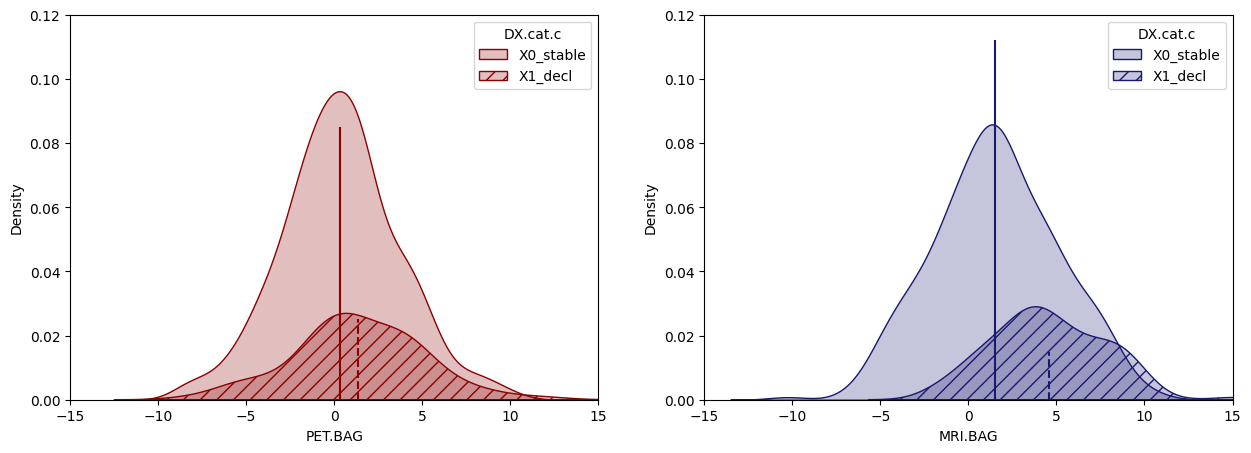

In [25]:
# One-way ANOVA tests as in Lee et al
print("FDG-PET BAG: ", ancova(data=df, dv="PET.BAG", between="DX.cat.n",
                              covar=['PTEDUCAT', 'APOE4', 'meanage', 'PTGENDER']))
print("MRI BAG: ", ancova(data=df, dv="MRI.BAG", between="DX.cat.n",
                              covar=['PTEDUCAT', 'APOE4', 'meanage', 'PTGENDER']))

pet_mean_0 = np.mean(df.loc[df['DX.cat.n'] == 0, ['PET.BAG']])
pet_mean_1 = np.mean(df.loc[df['DX.cat.n'] == 1, ['PET.BAG']])
mri_mean_0 = np.mean(df.loc[df['DX.cat.n'] == 0, ['MRI.BAG']])
mri_mean_1 = np.mean(df.loc[df['DX.cat.n'] == 1, ['MRI.BAG']])
print(f"Mean PET BAG stables: {pet_mean_0.values}, mean PET BAG decliners: {pet_mean_1.values}.\nMean MRI BAG stables: {mri_mean_0.values}, mean MRI BAG decliners: {mri_mean_1.values}.")


colors = {'FDG': ['darkred', 'darkred'], 'MRI': ['midnightblue', 'midnightblue']}

fig, ax = plt.subplots(1, 2, figsize=(15,5))
# Density plots
kde_pet = sns.kdeplot(data=df, x="PET.BAG", hue="DX.cat.c", palette=colors['FDG'], fill=True, ax=ax[0])
kde_pet.legend_.legend_handles[1].set_hatch("//")
kde_pet.collections[::-1][1].set_hatch("//")
kde_mri = sns.kdeplot(data=df, x="MRI.BAG", hue="DX.cat.c", palette=colors['MRI'], fill=True, ax=ax[1])
kde_mri.legend_.legend_handles[1].set_hatch("//")
kde_mri.collections[::-1][1].set_hatch("//")
ax[0].set_ylim(0, 0.12)
ax[1].set_ylim(0, 0.12)

# Plot means
# Manually adapt height of ymax to max of distribution
ax[0].vlines(pet_mean_0, ymin=0, ymax=0.085, label="mean X0_stable", color=colors['FDG'])
ax[0].vlines(pet_mean_1, ymin=0, ymax=0.0253, label="mean X1_decl", color=colors['FDG'], linestyles="--")
ax[1].vlines(mri_mean_0, ymin=0, ymax=0.112, label="mean X0_stable", color=colors['MRI'])
ax[1].vlines(mri_mean_1, ymin=0, ymax=0.015, label="mean X1_decl", color=colors['MRI'], linestyles="--")
ax[0].set_xlim(-15, 15)
ax[1].set_xlim(-15, 15)
# plt.savefig(f"../results/ADNI/{group}/2_cognitive decline/density_plots.png", bbox_inches="tight", dpi=300)
plt.show()

In [40]:
def check_colinearity(df, cols):
    # Compute correlation matrix
    corr = df[cols].corr()
    pval = df[cols].corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*corr.shape)
    p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
    corr = corr.round(2).astype(str) + p
    corr.to_csv(f"../results/ADNI/{group}/2_cognitive decline/feature_correlation_{group}.csv")

def cutoff_youdens_j(fpr,tpr,thresholds):
    j_scores = tpr-fpr
    j_ordered = sorted(zip(j_scores,thresholds))
    return j_ordered[-1][1]

def cognitive_outcome(df_init, feature_names, calibrate_probs=True):    
    # Initialize features
    feature_names = feature_names.copy()
    
    history_all = {}
    features_removed = []
    feature_coefs_all = 0
    
    # Define covariates. Don't correct for age if age is among predictors
    if 'meanage' in feature_names:
        covar_names = ['PTEDUCAT', 'APOE4', 'PTGENDER']
    else:
        covar_names = ['PTEDUCAT', 'APOE4', 'meanage', 'PTGENDER']

    # Initialize recursive feature elimination (running once for single-feature prediction)
    while len(feature_names) > 0 :
        # Remove NA values # TODO: for amyloid category
        df = df_init.copy().dropna(subset=feature_names+covar_names)
        print(f"{len(df.index)} subjects with full information.")
        
        # Split the data into features, target and covariates (for residual creation)
        X = df[feature_names]
        y = df['DX.cat.n']
        covars = df[covar_names]
        
        # Create the logistic regression model
        clf = LogisticRegression(max_iter=1000)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

        worst_coefficient = []
        coefficients_per_fold = []
        predictions = {'GT': [], 'PROBA': [], 'VAL': []}  # , 'PRED50': []}
        history = {'auc': [], 'features': []}  # 'accuracy': [], 'precision': [], 'recall': [], 
        for i, (train_idx, val_idx) in enumerate(cv.split(X,y)):
            X_train, X_val = X.values[train_idx], X.values[val_idx]
            y_train, y_val = y.values[train_idx], y.values[val_idx]
            covar_train, covar_val = covars.iloc[train_idx], covars.iloc[val_idx]
        
            # Fit GLM to controls of training data to create residuals
            # (control for age, sex, years of edu and APOE)
            # TODO @Kaustubh & Georgios: this would only work for single-feature prediction, if we want to do this, we could possibly use the MultiOutputRegressor from sklearn?
            X_train_controls = X_train[y_train==0]
            covar_train_controls = covar_train[y_train==0]
            glm = LinearRegression()
            glm.fit(covar_train_controls, X_train_controls)
            X_train = glm.predict(covar_train)
            X_val = glm.predict(covar_val)

            # Fit the estimator on the training data for this fold
            clf.fit(X_train, y_train)
            y_pred_prob = clf.predict_proba(X_val)[:, 1]

            # Calibration of posterior probabilities
            if calibrate_probs:
                calibrated_clf = CalibratedClassifierCV(clf)
                calibrated_clf.fit(X_train, y_train)

                y_pred_prob = calibrated_clf.predict_proba(X_val)[:, 1]
            
            predictions['VAL'].append(X_val)
            predictions['GT'].append(y_val)
            predictions['PROBA'].append(y_pred_prob)

            # Calculate and store performance metrics
            history['auc'].append(roc_auc_score(y_val, y_pred_prob))
            fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
            sens_spec = tpr + (1-fpr)
            max_idx = sens_spec.argmax()
            print(thresholds[max_idx])
            # bag_threshold = thresholds[max_idx]
            # print(cutoff_youdens_j(fpr,tpr,thresholds), print(bag_threshold))
            
            # Get the coefficients for this fold
            coefficients_per_fold.append(clf.coef_)
            worst_coefficient.append(feature_names[np.argmin(np.abs(clf.coef_[0]))])
  
        # Save metrics
        history['features'] = ' '.join(feature_names)
        history_all[len(feature_names)] = history
    
        # Get feature that was the worst in the majority of folds, remove it and proceed
        mf_worst = Counter(worst_coefficient)
        mf_worst = max(mf_worst, key=mf_worst.get)
        features_removed.append(mf_worst)
        
        # Show feature importance
        mean_coefs = np.mean(coefficients_per_fold, axis=0).tolist()[0]
        if len(feature_names) > 1:
            # Check colinearity of predictors
            check_colinearity(df, feature_names)
            feature_coefs_all = mean_coefs.copy()
            print("Coefficients of features:")
            print([(name_, feature_) for name_, feature_ in zip(feature_names, feature_coefs_all)])
        
        print("AUC: ", np.mean(history['auc']))
        
        if len(feature_names) == 1:
            break
        
        feature_names.remove(mf_worst)
    print("Feature importance: ", list(reversed(features_removed)), "\n")

    return clf, history_all, features_removed, feature_coefs_all, predictions

PET.BAG
460 subjects with full information.
0.2447829144403613
0.22199410878617856
0.2684427220125349
0.24084676769861163
0.26649685205742896
AUC:  0.536350870301721
Feature importance:  ['PET.BAG'] 

MRI.BAG
460 subjects with full information.
0.1952878032318001
0.25201978078889714
0.2694018202884689
0.2801915501975401
0.27117006747048916
AUC:  0.5661289372253455
Feature importance:  ['MRI.BAG'] 

Hippocampus_GMV
460 subjects with full information.
0.24284681427120186
0.24354681815731316
0.2523121036609103
0.24542437824452915
0.23888782074846743
AUC:  0.5885869769801717
Feature importance:  ['Hippocampus_GMV'] 

SUMMARYSUVR_WHOLECEREBNORM
326 subjects with full information.
0.2284460340254503
0.23748078556449806
0.1889933384107223
0.23211095707685653
0.21252086421334052
AUC:  0.7191729650440057
Feature importance:  ['SUMMARYSUVR_WHOLECEREBNORM'] 

Precuneus_SUVR
460 subjects with full information.
0.24697711724290253
0.2467964621038105
0.24849106670637022
0.2519139175934046
0.24299121

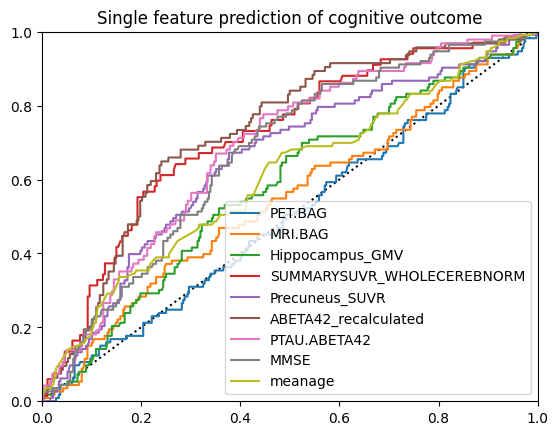

In [41]:
calibrate_probs = False

# Assess all numeric single features as predictors of cognitive outcome
single_feature_probabilities = {}
single_feature_gt = {}
cont_vars = ['PET.BAG', 'MRI.BAG', 'Hippocampus_GMV', 'SUMMARYSUVR_WHOLECEREBNORM', 'Precuneus_SUVR', 'ABETA42_recalculated', 'PTAU.ABETA42', 'MMSE', 'meanage']  # 'ABETA42.40': not enough observations
fig = plt.figure()
plt.plot([0, 1], linestyle="dotted", color="black")
for f in cont_vars:
    print(f)
    co = cognitive_outcome(df, [f], calibrate_probs=calibrate_probs)
    single_feature_probabilities[f] = [item_ for sublist in co[-1]['PROBA'] for item_ in sublist]
    single_feature_gt[f] = [item_ for sublist in co[-1]['GT'] for item_ in sublist]
    fpr, tpr, threshold = roc_curve(single_feature_gt[f], single_feature_probabilities[f])
    plt.plot(fpr, tpr, label=f)

plt.title("Single feature prediction of cognitive outcome")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.savefig(f"../results/ADNI/{group}/2_cognitive decline/AUC_biomarker_comparison.png", bbox_inches="tight")
plt.show()

460 subjects with full information.
0.1952878032318001
0.25201978078889714
0.2694018202884689
0.2801915501975401
0.27117006747048916
AUC:  0.5661289372253455
Feature importance:  ['MRI.BAG'] 



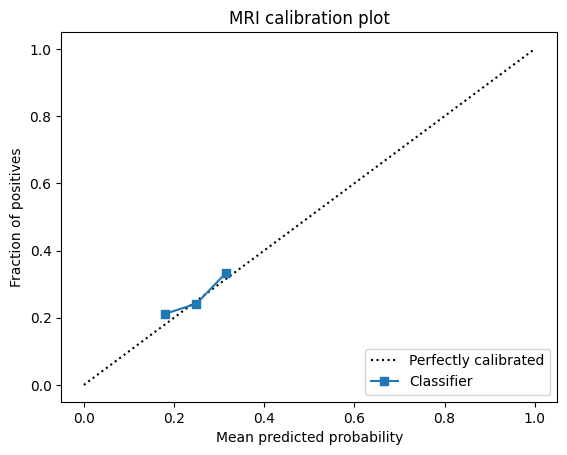

In [28]:
# Get model with only MRI
mri_bag_lr = cognitive_outcome(df, ['MRI.BAG'], calibrate_probs=False)
ground_truth = [item_ for sublist in mri_bag_lr[-1]['GT'] for item_ in sublist]
proba_mri = [item_ for sublist in mri_bag_lr[-1]['PROBA'] for item_ in sublist]
val = [item_[0] for sublist in mri_bag_lr[-1]['VAL'] for item_ in sublist]

fig, ax = plt.subplots()
CalibrationDisplay.from_predictions(ground_truth, proba_mri, n_bins=10, ax=ax)

ax.set_title("MRI calibration plot")
plt.show()